### SUPERVISED MACHINE LEARNING: MODELOS PARA DADOS DE CONTAGEM

UNIVERSIDADE DE SÃO PAULO

MBA DATA SCIENCE & ANALYTICS USP/ESALQ

Prof. Dr. Luiz Paulo Fávero

In [1]:
# Instalação dos pacotes.

# !pip install pandas
# !pip install numpy
# !pip install -U seaborn
# !pip install matplotlib
# !pip install plotly
# !pip install scipy
# !pip install statsmodels
# !pip install scikit-learn
# !pip install statstests

In [35]:
# Importação dos pacotes.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import exp, factorial
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP,ZeroInflatedPoisson
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
from scipy import stats
from statsmodels.iolib.summary2 import summary_col
from scipy.interpolate import interp1d
from statstests.tests import overdisp

import warnings
warnings.filterwarnings('ignore')

# A DISTRIBUIÇÃO POISSON

In [3]:
# Estabelecendo uma função da distribuição Poisson para determinados valores de lambda.

def poisson_lambda(lmbda,m):
    return (exp(-lmbda) * lmbda ** m) / factorial(m)

In [4]:
# Plotagem da função definida para diferentes valores de lambda.
m = np.arange(0,21)

lmbda_1 = []
lmbda_2 = []
lmbda_4 = []

for item in m:
    # Estabelecendo a distribuição com lambda = 1
    lmbda_1.append(poisson_lambda(1,item))
    # Estabelecendo a distribuição com lambda = 2
    lmbda_2.append(poisson_lambda(2,item))
    # Estabelecendo a distribuição com lambda = 4
    lmbda_4.append(poisson_lambda(4,item))

# Criando um dataframe com m variando de 0 a 20 e diferentes valores de lambda
df_lambda = pd.DataFrame({'m':m,
                          'lambda_1':lmbda_1,
                          'lambda_2':lmbda_2,
                          'lambda_4':lmbda_4})
df_lambda

,m,lambda_1,lambda_2,lambda_4
0,0,3.678794e-01,1.353353e-01,1.831564e-02
1,1,3.678794e-01,2.706706e-01,7.326256e-02
2,2,1.839397e-01,2.706706e-01,1.465251e-01
3,3,6.131324e-02,1.804470e-01,1.953668e-01
4,4,1.532831e-02,9.022352e-02,1.953668e-01
5,5,3.065662e-03,3.608941e-02,1.562935e-01
6,6,5.109437e-04,1.202980e-02,1.041956e-01
7,7,7.299195e-05,3.437087e-03,5.954036e-02
8,8,9.123994e-06,8.592716e-04,2.977018e-02
9,9,1.013777e-06,1.909493e-04,1.323119e-02


<function matplotlib.pyplot.show(close=None, block=None)>

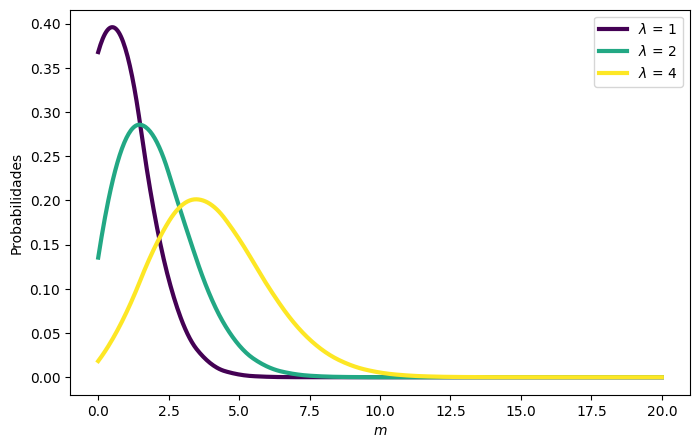

In [10]:
# Plotagem propriamente dita.

def smooth_line_plot(x,y):
    x_new = np.linspace(x.min(), x.max(),500)
    f = interp1d(x, y, kind='quadratic')
    y_smooth=f(x_new)
    return x_new, y_smooth

x_new, lambda_1 = smooth_line_plot(df_lambda.m, df_lambda.lambda_1)
x_new, lambda_2 = smooth_line_plot(df_lambda.m, df_lambda.lambda_2)
x_new, lambda_4 = smooth_line_plot(df_lambda.m, df_lambda.lambda_4)

plt.figure(figsize=(8,5))
plt.plot(x_new, lambda_1, linewidth=3, color='#440154FF')
plt.plot(x_new, lambda_2, linewidth=3, color='#22A884FF')
plt.plot(x_new, lambda_4, linewidth=3, color='#FDE725FF')
plt.xlabel('m', fontsize=10, style='italic')
plt.ylabel('Probabilidades', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend([r'$\lambda$ = 1',r'$\lambda$ = 2',r'$\lambda$ = 4'], fontsize=10)
plt.show

# REGRESSÃO PARA DADOS DE CONTAGEM

In [12]:
# Fisman, R.; Miguel, E. Corruption, Norms, and Legal Enforcement: Evidence from Diplomatic Parking Tickets.
# Journal of Political Economy, v. 15, n. 6, p. 1020-1048, 2007.
# https://www.journals.uchicago.edu/doi/abs/10.1086/527495

url = 'https://raw.githubusercontent.com/filipecarbonera/MBA_USP_Data_Science_Analytics/main/Modelos%20para%20Dados%20de%20Contagem/corruption.csv'

df_corruption = pd.read_csv(url, delimiter=',')
df_corruption.head()

,country,code,violations,staff,post,corruption
0,Angola,AGO,50,9,no,1.047506
1,Angola,AGO,1,9,yes,1.047506
2,Albania,ALB,17,3,no,0.921079
3,Albania,ALB,0,3,yes,0.921079
4,United Arab Emirates,ARE,0,3,no,-0.779468


In [13]:
# Características das variáveis do dataset.
df_corruption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     298 non-null    object 
 1   code        298 non-null    object 
 2   violations  298 non-null    int64  
 3   staff       298 non-null    int64  
 4   post        298 non-null    object 
 5   corruption  298 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 14.1+ KB


In [14]:
# Estatísticas univariadas.
df_corruption.describe()

,violations,staff,corruption
count,298.000000,298.000000,298.000000
mean,6.496644,11.805369,0.013641
std,18.210377,11.079558,1.012474
min,0.000000,2.000000,-2.582988
25%,0.000000,6.000000,-0.415147
50%,0.000000,9.000000,0.326959
75%,3.000000,14.000000,0.720250
max,167.000000,86.000000,1.582807


In [15]:
# Tabela de frequências da variável dependente 'violations'.

contagem = df_corruption['violations'].value_counts(dropna=False)
percent = (df_corruption['violations'].value_counts(dropna=False, normalize=True)*100).round(2)
table = pd.concat([contagem, percent], axis=1, keys=['contagem', '%'], sort=True)
table #'normalize=True', para gerar as contagens e os percentuais, respectivamente.

,contagem,%
violations,,
0,156,52.35
1,35,11.74
2,16,5.37
3,17,5.70
4,5,1.68
5,10,3.36
6,3,1.01
7,4,1.34
8,3,1.01


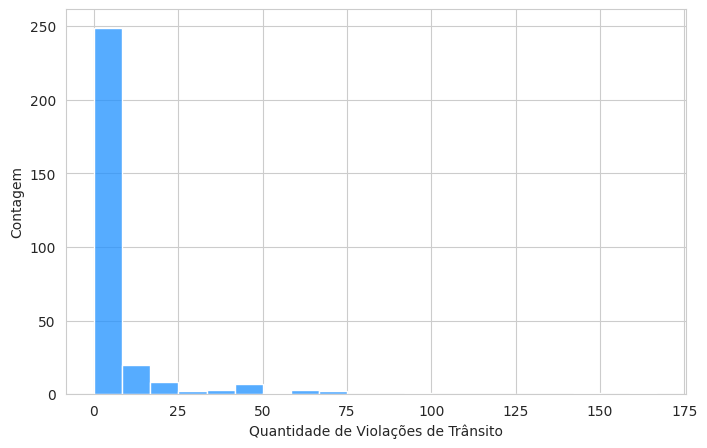

In [18]:
# Histograma da variável dependente 'violations'.

with sns.axes_style("whitegrid"):
    plt.figure(figsize=(8,5))
    sns.histplot(data=df_corruption, x='violations', bins=20,
                 color='dodgerblue', edgecolor='white', kde=False)
    plt.xlabel('Quantidade de Violações de Trânsito', fontsize=10)
    plt.ylabel('Contagem', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

In [19]:
# Diagnóstico preliminar para observação de eventual igualdade entre a média e a variância da variável dependente 'violations'.

pd.DataFrame({'Média':[df_corruption.violations.mean()],
              'Variância':[df_corruption.violations.var()]})

,Média,Variância
0,6.496644,331.617834


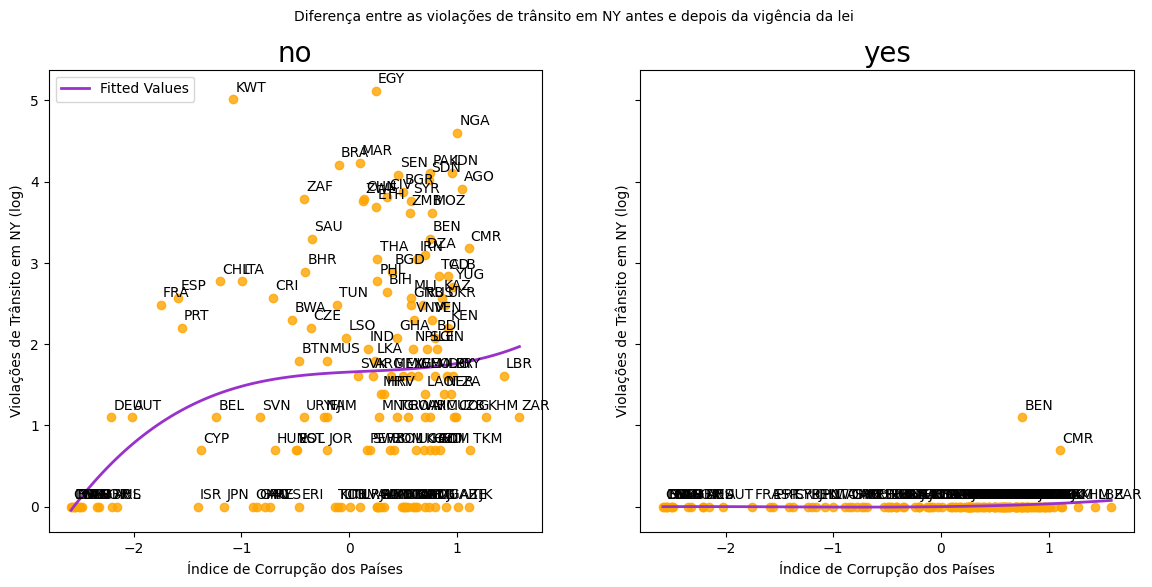

In [26]:
# Comportamento das variáveis 'corruption' e 'violations' antes e depois do início da vigência da lei.

fig, axs = plt.subplots(ncols=2, figsize=(14,6), sharey=True)

fig.suptitle('Diferença entre as violações de trânsito em NY antes e depois da vigência da lei',
             fontsize=10)

post = ['no', 'yes']

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y']+.1, str(point['val']))

for i, v in enumerate(post):
    df = df_corruption[df_corruption.post==v]
    df['violations'] = np.log(df.violations)
    df.loc[df['violations'] == np.inf, 'violations'] = 0
    df.loc[df['violations'] == -np.inf, 'violations'] = 0
    sns.regplot(data=df, x='corruption', y='violations',
                order=3, ax=axs[i], ci=False,
                line_kws={'color':'darkorchid', 'linewidth': 2,
                          'label':'Fitted Values'},
                scatter_kws={'color':'orange'})
    axs[i].set_title(v, fontsize=20)
    axs[i].set_ylabel("Violações de Trânsito em NY (log)", fontsize=10)
    axs[i].set_xlabel("Índice de Corrupção dos Países", fontsize=10)
    label_point(df.corruption, df.violations, df.code, axs[i])

for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=10)
    
axs[0].legend(loc='upper left', fontsize=10)

plt.show()

In [27]:
# Estimação do modelo Poisson.

# O argumento 'family=sm.families.Poisson()' da função 'smf.glm' define a estimação de um modelo Poisson.

modelo_poisson = smf.glm(formula='violations ~ staff + post + corruption',
                         data=df_corruption,
                         family=sm.families.Poisson()).fit()

# Parâmetros do 'modelo_poisson'.
modelo_poisson.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             violations   No. Observations:                  298
Model:                            GLM   Df Residuals:                      294
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2071.8
Date:                Tue, 10 Sep 2024   Deviance:                       3644.0
Time:                        19:44:17   Pearson chi2:                 6.77e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9999
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.2127      0.031     71.134      0.000       2.152       2.274
post[T.yes]    -4.2968      0.197    -21.762      0.000      -4.684      -3.910
staff           0.0219      0.001     17.807      0.000       0.019       0.024
corruption      0.3418      0.027     12.430      0.000       0.288       0.396
===============================================================================
"""

In [28]:
# Outro modo mais completo de apresentar os outputs do modelo, pela função 'summary_col'.

summary_col([modelo_poisson],
            model_names=["MODELO"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
        })

,MODELO
Intercept,2.2127***
,(0.0311)
post[T.yes],-4.2968***
,(0.1974)
staff,0.0219***
,(0.0012)
corruption,0.3418***
,(0.0275)
N,298
Log-lik,-2071.79


Todas as variáveis preditoras se mostraram estatisticamente diferentes de zero, considerando-se um nível de significância de 5%, ceteris paribus.

Porém, já se pode afirmar que a estimação Poisson é a mais adequada?

## TESTE DE SUPERDISPERSÃO DE CAMERON E TRIVEDI (1990)

CAMERON, A. C.; TRIVEDI, P. K. Regression-based tests for overdispersion in the Poisson model. Journal of Econometrics, v. 46, n. 3, p. 347-364, 1990.

- 1º Passo: estimar um modelo Poisson;
- 2º Passo: criar uma nova variável (Y*) utilizando os fitted values do modelo Poisson estimado anteriormente;
- 3º Passo: estimar um modelo auxiliar OLS, com a variável Y* como variável dependente, os fitted values do modelo Poisson como única variável preditora e sem o intercepto;
- 4º Passo: Observar a significância do parâmetro beta.

In [30]:
# Adicionando os fitted values do modelo Poisson ('lambda_poisson') ao dataframe.
df_corruption['lambda_poisson'] = modelo_poisson.fittedvalues
df_corruption.head()

,country,code,violations,staff,post,corruption,lambda_poisson
0,Angola,AGO,50,9,no,1.047506,15.919915
1,Angola,AGO,1,9,yes,1.047506,0.216711
2,Albania,ALB,17,3,no,0.921079,13.371720
3,Albania,ALB,0,3,yes,0.921079,0.182023
4,United Arab Emirates,ARE,0,3,no,-0.779468,7.477915


In [32]:
# Criando a nova variável Y* ('ystar').
df_corruption['ystar'] = (((df_corruption['violations']
                            -df_corruption['lambda_poisson'])**2)
                          -df_corruption['violations'])/df_corruption['lambda_poisson']
df_corruption.head()

,country,code,violations,staff,post,corruption,lambda_poisson,ystar
0,Angola,AGO,50,9,no,1.047506,15.919915,69.815208
1,Angola,AGO,1,9,yes,1.047506,0.216711,-1.783289
2,Albania,ALB,17,3,no,0.921079,13.371720,-0.286843
3,Albania,ALB,0,3,yes,0.921079,0.182023,0.182023
4,United Arab Emirates,ARE,0,3,no,-0.779468,7.477915,7.477915


In [33]:
# Estimando o modelo auxiliar OLS, sem o intercepto.
modelo_auxiliar = sm.OLS.from_formula('ystar ~ 0 + lambda_poisson', df_corruption).fit()

# Parâmetros do 'modelo_auxiliar'.
modelo_auxiliar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  ystar   R-squared (uncentered):                   0.025
Model:                            OLS   Adj. R-squared (uncentered):              0.022
Method:                 Least Squares   F-statistic:                              7.584
Date:                Tue, 10 Sep 2024   Prob (F-statistic):                     0.00625
Time:                        19:49:06   Log-Likelihood:                         -1952.9
No. Observations:                 298   AIC:                                      3908.
Df Residuals:                     297   BIC:                                      3911.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
lambda_poisson     2.6525      0.963      2.754      0.006       0.757       4.548
==============================================================================
Omnibus:                      607.263   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           446004.649
Skew:                          13.265   Prob(JB):                         0.00
Kurtosis:                     190.659   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Caso o p-value do parâmetro de lambda_poisson seja maior que 0.05, verifica-se a existência de equidispersão nos dados.

Caso contrário, diagnostica-se a existência de superdispersão nos dados, fato que favorecerá a estimação de um modelo binomial negativo, como ocorre nesse caso.

### Função 'overdisp'

Uma abordagem mais direta para a detecção da superdispersão pelo Teste de Cameron e Trivedi (1990) é por meio da utilização da função 'overdisp' do pacote 'statstests.tests'

Autores do pacote: Luiz Paulo Fávero e Helder Prado Santos

https://stats-tests.github.io/statstests/

In [36]:
# Elaboração direta do teste de superdispersão
overdisp(modelo_poisson, df_corruption)

Estimating model...: 
 GLM
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.022    
Dependent Variable:     ystar            AIC:                         3907.7809
Date:                   2024-09-10 19:51 BIC:                         3911.4780
No. Observations:       298              Log-Likelihood:              -1952.9  
Df Model:               1                F-statistic:                 7.584    
Df Residuals:           297              Prob (F-statistic):          0.00625  
R-squared (uncentered): 0.025            Scale:                       28915.   
-------------------------------------------------------------------------------------
            Coef.        Std.Err.         t          P>|t|        [0.025       0.975]
-------------------------------------------------------------------------------------
lmbda       2.6525         0.9632       2.7538       0.0063       0.7569       4.5480
-------------

Apenas para fins didáticos, caso considerássemos a estimação Poisson como a mais adequada, qual seria a quantidade média esperada de violações de trânsito para um país cujo corpo diplomático fosse composto por 23 membros, considerando o período anterior à vigência da lei e cujo índice de corrupção seja igual a 0.5?

In [37]:
modelo_poisson.predict(pd.DataFrame({'staff':[23],
                                     'post':['no'],
                                     'corruption':[0.5]}))

0    17.93284
dtype: float64

Qual seria a quantidade média esperada de violações de trânsito para o mesmo país, porém agora considerando a vigência da lei?

In [38]:
modelo_poisson.predict(pd.DataFrame({'staff':[23],
                                     'post':['yes'],
                                     'corruption':[0.5]}))

0    0.244112
dtype: float64

# A DISTRIBUIÇÃO BINOMIAL NEGATIVA